We're going to create ResNet for audio using the SEBasicBlock we created. Based on this paper : https://arxiv.org/pdf/2009.14153



![CleanShot 2024-10-18 at 16.26.54@2x.png](<attachment:CleanShot 2024-10-18 at 16.26.54@2x.png>)

The stride at the first layer is remoed compared to resnet-34. Attentive Statistic Pooling is used to aggregate temopral frames. where the channel-wise weighted std is calculated in addition to the weighted mean.
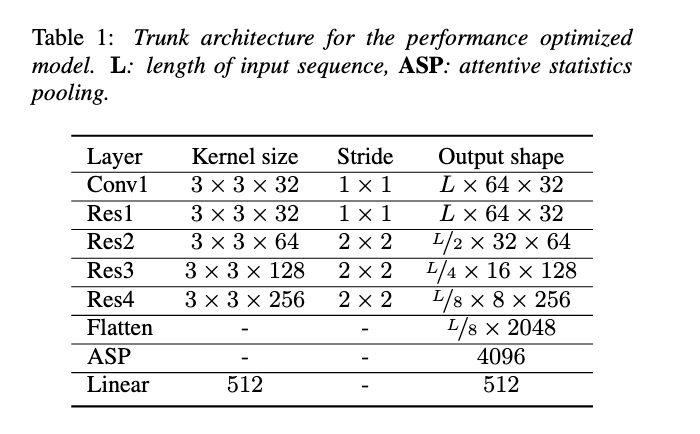

In [3]:
import jax
import equinox as eqx
import jax.tools
from SEBasicBlock import SEBasicBlock

class ResNet(eqx.Module):
    conv1: eqx.nn.Conv2d
    batch_norm: eqx.nn.BatchNorm

    layer1: list
    layer2: list
    layer3: list
    layer4: list

    instance_norm: eqx.nn.GroupNorm

    attention_conv1: eqx.nn.Conv1d
    attention_batch_norm: eqx.nn.BatchNorm
    attention_conv2: eqx.nn.Conv1d

    fc: eqx.nn.Linear

    def create_layer(self, channels_in, channels_out, layers, stride=1, key=None):

        downsample = None
        if type(stride) == int or channels_in != channels_out:
            key, grab = jax.random.split(key, 2)
            downsample = eqx.nn.Sequential([
                eqx.nn.Conv2d(channels_in, channels_out, kernel_size=1, stride=stride, use_bias=False, key=grab),
                eqx.nn.BatchNorm(channels_out, axis_name="batch", channelwise_affine=False)]
            )

        stack_of_blocks = []
        # print(key)
        key, grab = jax.random.split(key, 2)

        stack_of_blocks.append(SEBasicBlock(channels_in, channels_out, stride, downsample, key=grab))
        for _ in range(1, layers):

            key, grab = jax.random.split(key, 2)
            stack_of_blocks.append(SEBasicBlock(channels_out, channels_out, stride=1,key=grab))

        return stack_of_blocks
    
    def __init__(self, input_dims, proj_dim, layers=[3, 4, 6, 3], num_filters=[32, 64, 128, 256], key=None):
        # he_init = jax.nn.initializers.variance_scaling(scale=2.0, mode="fan_out", distribution="truncated_normal")

        key, grab = jax.random.split(key, 2)
        # TODO self.conv1 = eqx.nn.Conv2d(1, num_filters[0], key=grab, weight_init=he_init)
        self.conv1 = eqx.nn.Conv2d(1, num_filters[0], kernel_size=3, padding=1, key=grab)
        self.batch_norm = eqx.nn.BatchNorm(num_filters[0], axis_name="batch", channelwise_affine=False)

        key, key1, key2, key3, key4 = jax.random.split(key, 5)
        self.layer1 = self.create_layer(num_filters[0], num_filters[0], layers[0], key=key2)
        self.layer2 = self.create_layer(num_filters[0], num_filters[1], layers[1], stride=(2,2), key=key3)
        self.layer3 = self.create_layer(num_filters[1], num_filters[2], layers[2], stride=(2,2), key=key4)
        self.layer4 = self.create_layer(num_filters[2], num_filters[3], layers[3], stride=(2,2), key=key1)

        # Instance norm seems to be a specific example of groupnorm.
        self.instance_norm = eqx.nn.GroupNorm(1, channelwise_affine=False)

        key, key1, key2 = jax.random.split(key, 3)

        # Basically a FFN but without needing to deal with the channel dimensions.
        # doesn't really explain the lowering of dimensions in the middle though...
        current_channel_size = int(num_filters[3] * input_dims / 8)
        self.attention_conv1 = eqx.nn.Conv1d(current_channel_size, 128, kernel_size=1, key=key1)
        self.attention_batch_norm = eqx.nn.BatchNorm(128, axis_name="batch", channelwise_affine=False)
        self.attention_conv2 = eqx.nn.Conv1d(128, current_channel_size, kernel_size=1, key=key2)
        #TODO  nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")

        #Encoder type is ASP, thus the current dims are B, Input_dim / 8 because of the 4 layers,  * 2 * output of layer4.
        self.fc = eqx.nn.Linear(current_channel_size * 2, proj_dim, key=key)

    def __call__(self, x, state):
        y = x

        # We expect a mel spectrogram as input for now.
        # y = self.torch_spec(y)
        # print(y.shape)
        y = self.instance_norm(y)
        # y = jax.numpy.expand_dims(y, 0)
        # print(y.shape)

        y = self.conv1(y)
        # print(y.shape)

        y = jax.nn.relu(y)
        y, state = self.batch_norm(y, state)
        # print(y.shape)
        # y, state = self.test(y, state)
        for block in self.layer1:
            y, state = block(y, state)
            # print(y.shape)

        for block in self.layer2:
            y, state = block(y, state)

        for block in self.layer3:
            y, state = block(y, state)

        for block in self.layer4:
            y, state = block(y, state)

        y = jax.numpy.reshape(y, (-1, y.shape[-1]))

        # TODO not really justified...
        w = self.attention_conv1(y)
        w = jax.nn.relu(w)
        w, state = self.attention_batch_norm(w, state)
        w = self.attention_conv2(w) # W represents the 
        w = jax.nn.softmax(w, axis=1)


        mu = jax.numpy.sum(y * w, axis=1)
        sg = jax.numpy.sqrt(jax.numpy.sum((y ** 1) * w, axis=1) - mu**2)
        sg = jax.lax.clamp(min=1e-5, x=sg, max=jax.numpy.float32(10))

        y = jax.lax.concatenate((mu, sg), 0)

        y = self.fc(y)

        return y, state


In [14]:

@eqx.filter_jit
def loss(model, state, x, y):
    res, state = jax.vmap(model, in_axes=(0, None), out_axes=(0, None), axis_name="batch")(x, state)
    return jax.numpy.mean((res - y) ** 2), state

loss = eqx.filter_grad(loss, has_aux=True)

key = jax.random.PRNGKey(seed = 69)
key1, key2, key3 = jax.random.split(key, 3)
x = jax.random.normal(key1, (1, 1, 64, 32)).astype(jax.numpy.float32)
y = jax.random.normal(key2, (1, 512)).astype(jax.numpy.float32)

model, state = eqx.nn.make_with_state(ResNet)(64, 512, key=key3)
grads, state = loss(model, state, x, y)

Other things that I could implement to get a better version:

![CleanShot 2024-10-18 at 15.57.58@2x.png](<attachment:CleanShot 2024-10-18 at 15.57.58@2x.png>)
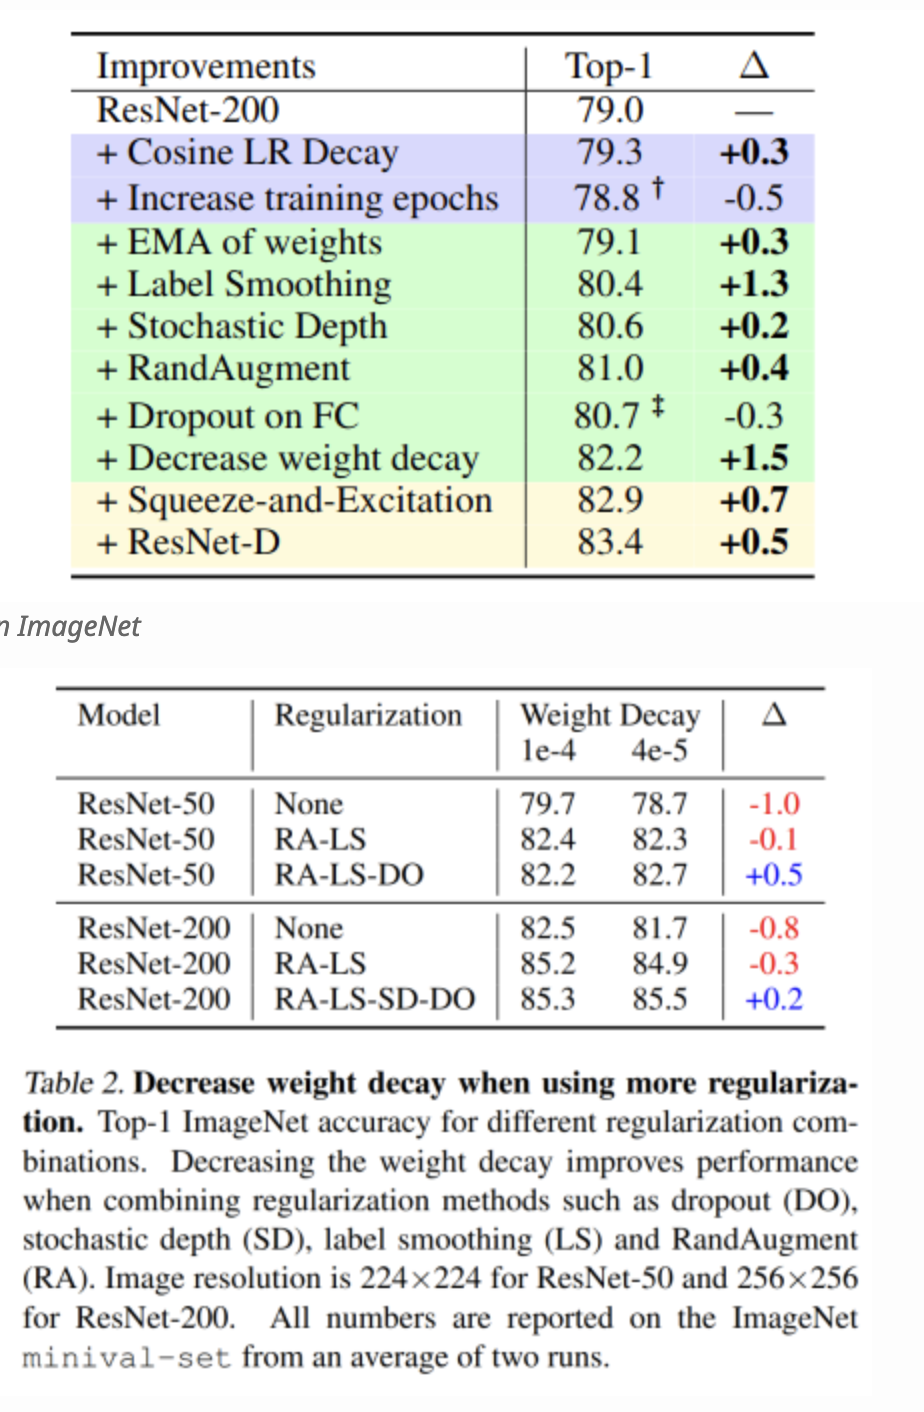